In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
datasetPath = "/home/flupec/datasets/{}/images/"
trainSubst = "WIDER_train"
testSubst = "WIDER_test"
validateSubst = "WIDER_val"

trainPath = datasetPath.format(trainSubst)
testPath = datasetPath.format(testSubst)
validatePath = datasetPath.format(validateSubst)

labelPath = "/home/flupec/datasets/wider_face_split/{}"
trainSubst = "wider_face_train_bbx_gt.txt"
validateSubst = "wider_face_val_bbx_gt.txt"

labelTrainPath = labelPath.format(trainSubst)
labelValidatePath = labelPath.format(validateSubst)

class LabeledImage:
    def __init__(self, relativeImgPath, absPath, bboxes):
        self.relativePath = relativeImgPath
        self.absPath = absPath
        self.bboxes = bboxes
        self.bboxesInterpolated = False
    
    def loadCvImage(self):
        img = cv.imread(self.absPath)
        
        # проинтерполируем ббоксы
        if not self.bboxesInterpolated:
            newbboxes = [[]] * len(self.bboxes)
            for i in range(len(self.bboxes)):
                # да, h и w перепутаны местами
                x, y, w, h = self.bboxes[i]
                x, y, w, h = int(x), int(y), int(w), int(h)

                x2 = x + h
                y2 = y + w

                newx = int(x / img.shape[0] * IMSIZE)
                newy = int(y / img.shape[1] * IMSIZE)

                newx2 = int(x2 / img.shape[0] * IMSIZE)
                newy2 = int(y2 / img.shape[1] * IMSIZE)

                newh = newx2 - newx
                neww = newy2 - newy

    #             newh = int(h / (img.shape[0] - x) * (IMSIZE - x)) + newx
    #             neww = int(w / (img.shape[1] - y) * (IMSIZE - y)) + newy
                # Сохраняем перепутанность местами
                newbboxes[i] = [newx, newy, neww, newh]

            print('was', self.bboxes)
            print("become", newbboxes)
            self.bboxes = newbboxes
            self.bboxesInterpolated = True
        
        # проинтерполируем исходное изображение
        img = cv.resize(img, dsize=[IMSIZE, IMSIZE], interpolation=cv.INTER_CUBIC)
        
        img = img.swapaxes(0, 2)
        return img
    
    def generateValidAnchors(self)->np.array:
        img = self.loadCvImage()
        centersX = np.arange(0, IMSIZE, GRID_CELL_SIZE)
        centersY = np.arange(0, IMSIZE, GRID_CELL_SIZE)
        anchors = []
        for centerX in centersX:
            for centerY in centersY:
                for ratio in ratios:
                    for scale in scales:
                        h = GRID_CELL_SIZE * scale * ratio
                        w = GRID_CELL_SIZE * scale * 1 / ratio
                        h = min(IMSIZE - centerX, h)
                        w = min(IMSIZE - centerY, w)
                        anchors.append([centerX, centerY, h, w])
        return np.array(anchors)
    
    def generateIousVersusBbox(self, anchors)->np.array:
        anchorsAmount, gtBoxAmount = anchors.shape[0], len(self.bboxes)
        ious = np.zeros([anchorsAmount, gtBoxAmount])
        for i in range(anchorsAmount):
            anchor = anchors[i]
            for j in range(gtBoxAmount):
                iou = bb_intersection_over_union(anchor, self.bboxes[j])
                ious[i, j] = iou
        return ious
    
    def getBboxesNumpy(self)->np.array:
        return np.array(self.bboxes).astype(np.int)
            
    
    def __str__(self):
        return "absPath={}, relativePath={}, bboxes={}".format(self.absPath, self.relativePath, self.bboxes)

def datasetsImagePaths(basePath)->[str]:
    paths = []
    for currdir, subdirs, _ in os.walk(trainPath):
        for d in subdirs:
            for _, _, files in os.walk(trainPath + "/" + d):
                for f in files:
                    foundPath = trainPath + d + "/" + f
                    paths.append(foundPath)
    return paths

def getBoundindBoxesForLabeledImages(fullImgPathes: [str], train: bool)->dict:
    imgPathes = {}
    absPathes = {}
    
    for p in fullImgPathes:
        splitpath = p.split("/")
        file = splitpath[-1]
        folder = splitpath[-2]
        labeledPath = folder + "/" + file
        imgPathes[labeledPath] = []
        absPathes[labeledPath] = p
    labelPath = labelTrainPath if train else labelValidatePath # TODO: Test set??
    lines = open(labelPath, "r").readlines()

    for l in range(len(lines)):
        labelFilePath = lines[l].split("\n")[0]
        if labelFilePath in imgPathes: # found corresponding image in imgPathes
            bboxAmount = int(lines[l + 1].split("\n")[0])
            for bboxIdx in range(bboxAmount):
                bboxLine = lines[l + 2 + bboxIdx].split("\n")[0]
                bboxLineSplit = bboxLine.split(" ")
                x, y, w, h = bboxLineSplit[0], bboxLineSplit[1], bboxLineSplit[2], bboxLineSplit[3]
                valid = int(bboxLineSplit[7])  == 0
                if valid:
                    imgPathes.get(labelFilePath, []).append((x, y, w, h))
                
    newImgPathes = {}
    for k in imgPathes:
        newImgPathes[k] = LabeledImage(k, absPathes[k], imgPathes[k])
    return newImgPathes

In [3]:
trainPathes = datasetsImagePaths(trainPath)
labeledImages = getBoundindBoxesForLabeledImages(trainPathes, True)

# TODO: Load Validate set and maybe Test set?

assert len(trainPathes) == len(labeledImages)

In [4]:
# import time
# import pickle

# for k in labeledImages:
#     labeledImg = labeledImages[k]
#     baseImg = cv.imread(labeledImg.absPath)
    
#     absSplit = labeledImg.absPath.split("/")
#     dirAbsPath = "/".join(absSplit[0: -1])
#     fileName = absSplit[-1]
    
#     selectiveSearchDirAbsPath = dirAbsPath + "/select-search"
#     try:
#         os.mkdir(selectiveSearchDirAbsPath)
#     except Exception as e:
#         print("Error at making dir " + selectiveSearchDirAbsPath)
#         print(e)
    
#     selectiveSearchFileAbsPath = selectiveSearchDirAbsPath + "/" + fileName
    
#     ss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()
#     ss.setBaseImage(baseImg)
#     ss.switchToSelectiveSearchFast()
#     rects = ss.process()
    
#     # Saving pickle objects as absPath (/abspath/image-name.jpg is a pickle dumped object with bbox rectangles)
#     with open(selectiveSearchFileAbsPath, "wb") as f:
#         pickle.dump(rects, f)
#         print("saved {}".format(selectiveSearchFileAbsPath))

In [5]:
import torch, torchvision
import torch.nn as nn
model = torchvision.models.vgg16(pretrained=True)
model = torch.nn.Sequential(*list(model.features)[0: -1])

was [('20', '134', '82', '122'), ('106', '126', '98', '130'), ('208', '114', '104', '128'), ('360', '34', '100', '158'), ('460', '54', '116', '158'), ('726', '124', '64', '128'), ('784', '96', '86', '134'), ('882', '100', '88', '150')]
become [[14, 67, 41, 86], [74, 63, 49, 92], [146, 57, 52, 90], [253, 17, 50, 111], [323, 27, 58, 112], [511, 62, 32, 90], [552, 48, 43, 94], [621, 50, 44, 105]]
(1, 512, 32, 32)


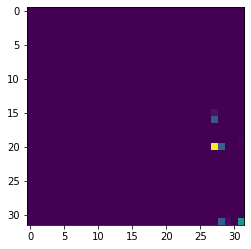

In [6]:
IMSIZE = 512
def tensorFromCvReaded(img: LabeledImage)->torch.Tensor:
    image = img.loadCvImage()
    newImg = np.zeros([1, *image.shape])
    newImg[0] = image
    return torch.Tensor(newImg)
    
it = iter(labeledImages)
next(it)
next(it)
next(it)
randomLabeledImage = labeledImages[next(it)]
randomImageTensor = tensorFromCvReaded(randomLabeledImage)

result = model.forward(randomImageTensor)
# output is 3, 512, 32, 32
print(result.detach().numpy().shape)
plt.imshow(result.detach().numpy()[0][100])

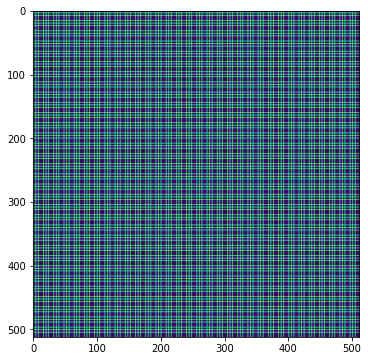

In [7]:
GRID_CELL_SIZE = 16

ratios = (0.5, 1, 2)
scales = (0.5, 1, 4, 8, 16)

def visualizeAnchor(anchoredImage):
    drawImg = np.zeros([512, 512])
    for i, anchor in enumerate(anchoredImage):
#         if i < 641 or i > 648: # Tune it for visualizing grid cell!
#             continue
        x, y = int(anchor[0]), int(anchor[1])
        h, w = int(anchor[2]), int(anchor[3])
        x, y = max(0, x), max(0, y)
        h, w = min(h, IMSIZE), min(w, IMSIZE)
        cv.rectangle(drawImg, [x, y], [x + h, y + w], [255, 255, 255], 1)

    plt.figure(figsize=[6,6])
    plt.imshow(drawImg)


visualizeAnchor(randomLabeledImage.generateValidAnchors())

In [8]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(int(boxA[0]), int(boxB[0]))
    yA = max(int(boxA[1]), int(boxB[1]))
    xB = min(int(boxA[2]) + int(boxA[0]), int(boxB[2]) + int(boxB[0]))
    yB = min(int(boxA[3]) + int(boxA[1]), int(boxB[3]) + int(boxB[1]))

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((int(boxA[2]) - int(boxA[0])) * (int(boxA[3]) - int(boxA[1])))
    boxBArea = abs((int(boxB[2]) - int(boxB[0])) * (int(boxB[3]) - int(boxB[1])))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [9]:
faceAmountKey = max(labeledImages, key=lambda k: len(labeledImages[k].bboxes))
MAX_FACE_AMOUNT = len(labeledImages[faceAmountKey].bboxes)

def getImgWithGT(image: LabeledImage)->np.array:
    img = image.loadCvImage()
    img = img.swapaxes(0,2)  
    for i, gt in enumerate(image.bboxes):
        x, y = int(gt[0]), int(gt[1])
        h, w = int(gt[3]), int(gt[2])
        x, y = max(0, x), max(0, y)
        h, w = min(h, IMSIZE), min(w, IMSIZE)
        cv.rectangle(img, [x, y], [x + h, y + w], [255, 0, 0], 4)
        cv.putText(img, "{}".format(i), (x, y), cv.FONT_HERSHEY_SIMPLEX, 
                   0.5, (0, 255, 0), 2, cv.LINE_AA)
   
    return img

In [ ]:
img = getImgWithGT(randomLabeledImage)

# TODO Надо при интерполяции картинок также интерполировать GT боксы

plt.figure(figsize=[10,10])
plt.imshow(img)

randomLabeledImage.__init__(randomLabeledImage.relativePath, randomLabeledImage.absPath, randomLabeledImage.bboxes)

In [11]:
POSITIVE_LABEL_THRESHOLD = 0.7
NEGATIVE_LABEL_THRESHOLD = 0.3

POSITIVE_LABEL = 1
NEGATIVE_LABEL = 0
NOT_CONTRIBUTE_LABEL = -1

def getAnchorsGtsLocsLabels(labeledImage)->(np.array, np.array, np.array, np.array):
    """
        Возвращает якори, им соответствующие гт боксы с макс площадью
        пересечения и расстояния (locs) между якорем и гт боксом и метки
    """
    anchor = labeledImage.generateValidAnchors()
    ious = labeledImage.generateIousVersusBbox(anchor)
    maxIouIdx = np.argmax(ious, axis=1) # 

    bboxes = labeledImage.getBboxesNumpy()

    # Находим gt боксы для каждого якоря с максимальным IOU
    maxbboxes = []
    for i in range(ious.shape[0]):
        maxbboxes.append(bboxes[maxIouIdx[i]])

    maxGts = np.vstack(maxbboxes) # ГТ боксы для каждого якоря

    # Находим метки (labels)
    labels = np.zeros(anchor.shape[0], dtype=np.int32)
    labels = NOT_CONTRIBUTE_LABEL * labels # не учавствующие раввны -1
    for i in range(anchor.shape[0]):
        # Метка положительная если пересечение существенно
        if len(np.where(ious[i, :] >= POSITIVE_LABEL_THRESHOLD)[0]) > 0:
            labels[i] = POSITIVE_LABEL
    labels[np.argmax(ious, axis=0)] = POSITIVE_LABEL
    # Метка отрицательная если пересечение несущественно
    for i in range(len(labels)):
        denotedAsBackground = labels[i] == NOT_CONTRIBUTE_LABEL and np.all(ious[i, :] < NEGATIVE_LABEL_THRESHOLD)
        if denotedAsBackground:
            labels[i] = NEGATIVE_LABEL

    # Находим anchor locs
    locs = []
    for i in range(ious.shape[0]):
        xMidGt = (maxGts[i, 0] + maxGts[i, 3]) / 2 # [x, y, w, h]
        yMidGt = (maxGts[i, 1] + maxGts[i, 2]) / 2
        xMidAnchor = (anchor[i, 0] + anchor[i, 2]) / 2 # [x, y, h, w]
        yMidAnchor = (anchor[i, 1] + anchor[i, 3]) / 2
        tx = (xMidGt - xMidAnchor) / anchor[i, 2]
        ty = (yMidGt - yMidAnchor) / anchor[i, 3]
        th = np.log(maxGts[i, 3] / anchor[i, 2])
        tw = np.log(maxGts[i, 2] / anchor[i, 3])
        locs.append([tx, ty, th, tw])

    anchorLocs = np.vstack(locs)
    
    return anchor, maxGts, anchorLocs, labels

# test
anchors, maxGts, anchorLocs, labels = getAnchorsGtsLocsLabels(randomLabeledImage)
print(anchors.shape)
print(maxGts.shape)
print(anchorLocs.shape)
print(labels.shape)

(15360, 4)
(15360, 4)
(15360, 4)
(15360,)


In [12]:
anchorsNum = len(ratios) * len(scales)
conv1 = nn.Conv2d(IMSIZE, 512, 3, 1, 1)
regLayer = nn.Conv2d(512, anchorsNum * 4, 1, 1, 0)
clsLayer = nn.Conv2d(512, anchorsNum * 2, 1, 1, 0)

In [13]:
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()# Regression layer
regLayer.weight.data.normal_(0, 0.01)
regLayer.bias.data.zero_()# classification layer
clsLayer.weight.data.normal_(0, 0.01)
clsLayer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [14]:
# test to see shapes
x = conv1(result)
print(x.shape)
predAnchorLocs = regLayer(x)
predClsScores = clsLayer(x)

print(predAnchorLocs.shape)
print(predClsScores.shape)

objectnessScore = predClsScores.view(1, 30, 32, 16, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectnessScore.shape)

predAnchorLocs = predAnchorLocs.contiguous().view(1, -1, 4)
print(predAnchorLocs.shape)

predClsScores = predClsScores.contiguous().view(1, -1, 2)
print(predClsScores.shape)

assert predAnchorLocs.shape[1] == anchors.shape[0] == predClsScores.shape[1]

torch.Size([1, 512, 32, 32])
torch.Size([1, 60, 32, 32])
torch.Size([1, 30, 32, 32])
torch.Size([1, 15360])
torch.Size([1, 15360, 4])
torch.Size([1, 15360, 2])


In [15]:
def bboxFromPredicted(predLocs: torch.Tensor, anchors: np.array)->np.array:
    assert predLocs.shape[1] == anchors.shape[0]
    # [tx, ty, th, tw] is input for each predLocs
    # find [xc, yc, h, w] and then [x, y, h, w]
    predLocsNumpy = predLocs[0].data.numpy()
    
    predictedBboxes = []
    for i in range(anchors.shape[0]):
        hAnchor, wAnchor = anchors[i, 2], anchors[i, 3]
        
        xMidAnchor = (anchors[i, 0] + hAnchor) / 2
        yMidAnchor = (anchors[i, 1] + wAnchor) / 2
         
        tx, ty, th, tw = predLocsNumpy[i, :]
        
        xc = tx * hAnchor + xMidAnchor
        yc = ty * wAnchor + yMidAnchor
        
        h = np.exp(th) * hAnchor
        w = np.exp(tw) * wAnchor
        
        x = xc - h / 2
        y = yc - w / 2
        
        h = min(IMSIZE - x, h)
        w = min(IMSIZE - y, w)
        
        predictedBboxes.append([x, y, h, w])
    
    return np.vstack(predictedBboxes)

nmsThreshold = 0.7
bboxNumBeforeNmsTrain = 6000
bboxNumAfterNmsTrain = 1000

bboxNumBeforeNmsTest = 3000
bboxNumAfterNmsTest = 100
roiMinSize = 16

In [16]:
def generateRoiProposals(predLocs: torch.Tensor, predScores: torch.Tensor, objectnessScores: torch.Tensor, anchors: np.array, train: bool):
    # Convert coordinates
    bboxPredLocs = bboxFromPredicted(predLocs, anchors)
    print(bboxPredLocs.shape)
    # Filter by width and height size and by x and y at fact that lies withit window
    notSmallIdx = np.where(
        (bboxPredLocs[:, 2] > roiMinSize) &
        (bboxPredLocs[:, 3] > roiMinSize) &
        (bboxPredLocs[:, 0] >= 0) &
        (bboxPredLocs[:, 0] < IMSIZE) &
        (bboxPredLocs[:, 1] >= 0) &
        (bboxPredLocs[:, 1] < IMSIZE)
    )[0]

    bboxPredLocs = bboxPredLocs[notSmallIdx]
    print(bboxPredLocs.shape)
    anchors = anchors[notSmallIdx]
#     predScores = predScores[notSmallIdx]
    objectnessScores = objectnessScores.data.numpy()[:, notSmallIdx]
    
    # Non maximum supression
    sortByScoreIdx = np.argsort(objectnessScores)[::-1]
    if train:
        sortByScoreIdx = sortByScoreIdx[:bboxNumBeforeNmsTrain]
    else:
        sortByScoreIdx = sortByScoreIdx[:bboxNumBeforeNmsTest]
    
    nmsResultIdxes = []
    good = [True for i in range(len(sortByScoreIdx))]
    
    for i in range(len(sortByScoreIdx)):
        if not good[i]:
            continue    
        firstIdx = sortByScoreIdx[i]
        first = bboxPredLocs[firstIdx]
        nmsResultIdxes.append(firstIdx)
        
        for j in range(i + 1, len(sortByScoreIdx)):
            secondIdx = sortByScoreIdx[j]
            second = bboxPredLocs[secondIdx]
            if bb_intersection_over_union(first, second) > 0.7:
                good[j] = False
    
    nmsResultIdxes = np.vstack(nmsResultIdxes)
    if train:
        nmsResultIdxes = nmsResultIdxes[:, bboxNumAfterNmsTrain]
    else:
        nmsResultIdxes = nmsResultIdxes[:, bboxNumAfterNmsTest]

    print(nmsResultIdxes)
    print(nmsResultIdxes.shape)
    # Got non maximum supressed ROI's
    bboxPredLocs = bboxPredLocs[nmsResultIdxes]
    print(bboxPredLocs.shape)
    anchors = anchors[nmsResultIdxes]
#     predScores = predScores[nmsResultIdxes]
    objectnessScores = objectnessScores[:, nmsResultIdxes]
                
    return bboxPredLocs

In [17]:
# Train
for imgPath in labeledImages:
    print(imgPath)
    
    # TODO:
    # 0--Parade/0_Parade_Parade_0_600.jpg
    # Raises ZeroDivisionError
    
    labeledImage = labeledImages[imgPath]
    tensorLabeledImage = tensorFromCvReaded(labeledImage)
    
    afterBackbone = model.forward(tensorLabeledImage)
    
    anchors, maxGts, anchorLocs, labels = getAnchorsGtsLocsLabels(labeledImage)
    
    x = conv1(afterBackbone)
    
    predAnchorLocs = regLayer(x)
    predClsScores = clsLayer(x)
    
    objectnessScore = predClsScores.view(1, 30, 32, 16, 2)[:, :, :, :, 1].contiguous().view(1, -1)
    predAnchorLocs = predAnchorLocs.contiguous().view(1, -1, 4)
    predClsScores = predClsScores.contiguous().view(1, -1, 2)
    
    assert predAnchorLocs.shape[1] == anchors.shape[0] == predClsScores.shape[1]
    
    roiProposals = generateRoiProposals(predAnchorLocs, predClsScores, objectnessScore, anchors, True)
    
    print("Roi proposals", roiProposals.shape)
    print("anchors", anchors.shape)
    print("labels", labels.shape)

0--Parade/0_Parade_marchingband_1_35.jpg
was [('450', '170', '59', '46'), ('214', '259', '13', '13'), ('178', '250', '18', '19'), ('136', '254', '16', '14'), ('110', '245', '13', '11'), ('294', '251', '11', '12'), ('307', '251', '8', '10'), ('338', '245', '17', '11'), ('845', '245', '8', '10'), ('733', '257', '19', '21'), ('782', '251', '13', '15'), ('681', '239', '14', '15'), ('638', '254', '17', '16'), ('597', '247', '11', '12'), ('615', '252', '7', '7'), ('719', '256', '7', '7'), ('260', '252', '9', '9'), ('915', '253', '9', '9'), ('962', '249', '12', '10'), ('993', '259', '17', '16'), ('857', '259', '24', '23')]
become [[400, 85, 29, 40], [190, 129, 7, 11], [158, 125, 9, 17], [120, 127, 8, 13], [97, 122, 7, 10], [261, 125, 6, 11], [272, 125, 4, 9], [300, 122, 9, 10], [751, 122, 4, 9], [651, 128, 10, 19], [695, 125, 7, 13], [605, 119, 7, 13], [567, 127, 8, 14], [530, 123, 6, 11], [546, 126, 3, 6], [639, 128, 3, 6], [231, 126, 4, 8], [813, 126, 5, 8], [855, 124, 6, 9], [882, 129, 9, 

(15360, 4)
(2527, 4)
[356]
(1,)
(1, 4)
Roi proposals (1, 4)
anchors (15360, 4)
labels (15360,)
0--Parade/0_Parade_Parade_0_415.jpg
was [('868', '255', '7', '10'), ('745', '243', '9', '12'), ('737', '261', '12', '14'), ('725', '247', '6', '7'), ('688', '236', '9', '11'), ('682', '257', '15', '17'), ('653', '245', '12', '15'), ('606', '256', '15', '17'), ('584', '245', '6', '7'), ('559', '252', '10', '13'), ('533', '236', '10', '10'), ('488', '235', '8', '11'), ('463', '232', '14', '17'), ('425', '233', '15', '18'), ('390', '229', '7', '8'), ('318', '226', '15', '20'), ('286', '227', '7', '11'), ('219', '239', '14', '19'), ('201', '219', '15', '20'), ('129', '214', '16', '18')]
become [[578, 127, 4, 7], [496, 121, 5, 8], [491, 130, 6, 9], [483, 123, 3, 5], [458, 118, 4, 8], [454, 128, 8, 12], [435, 122, 6, 10], [404, 128, 7, 11], [389, 122, 3, 5], [372, 126, 5, 9], [355, 118, 5, 7], [325, 117, 4, 7], [308, 116, 7, 12], [283, 116, 8, 12], [260, 114, 4, 5], [212, 113, 7, 13], [190, 113, 4,

(15360, 4)
(4334, 4)
[1750]
(1,)
(1, 4)
Roi proposals (1, 4)
anchors (15360, 4)
labels (15360,)
0--Parade/0_Parade_marchingband_1_33.jpg
was [('438', '632', '14', '17'), ('327', '628', '16', '18'), ('200', '625', '14', '18'), ('80', '631', '16', '18'), ('96', '458', '15', '17'), ('533', '664', '17', '21'), ('576', '618', '15', '16'), ('696', '599', '17', '19'), ('798', '624', '18', '17'), ('890', '605', '16', '17'), ('903', '560', '15', '16'), ('847', '528', '13', '15'), ('815', '511', '12', '14'), ('750', '475', '11', '14'), ('743', '458', '9', '14'), ('718', '440', '11', '14'), ('643', '409', '10', '13'), ('838', '375', '10', '11'), ('765', '361', '11', '13'), ('714', '346', '9', '11'), ('647', '337', '8', '9'), ('578', '325', '8', '10'), ('540', '344', '8', '10'), ('576', '376', '7', '10'), ('226', '353', '10', '10'), ('218', '240', '6', '9'), ('181', '217', '6', '8'), ('201', '204', '6', '8'), ('496', '203', '6', '7'), ('446', '199', '6', '7'), ('421', '202', '6', '7'), ('404', '20

(15360, 4)
(5162, 4)
[4271]
(1,)
(1, 4)
Roi proposals (1, 4)
anchors (15360, 4)
labels (15360,)
0--Parade/0_Parade_Parade_0_152.jpg
was [('268', '406', '12', '17'), ('300', '410', '13', '13'), ('340', '407', '10', '13'), ('175', '389', '11', '11'), ('130', '446', '12', '14'), ('181', '441', '10', '14'), ('280', '321', '8', '11'), ('317', '351', '9', '11'), ('86', '345', '10', '10'), ('98', '375', '10', '12'), ('284', '362', '11', '13'), ('231', '371', '8', '10'), ('229', '319', '8', '10'), ('211', '282', '6', '9'), ('235', '273', '6', '9'), ('180', '316', '8', '9'), ('344', '331', '8', '12'), ('457', '322', '10', '13'), ('398', '329', '9', '11'), ('382', '321', '9', '12'), ('369', '312', '10', '11'), ('364', '310', '9', '12'), ('360', '311', '7', '10'), ('525', '320', '10', '12'), ('498', '312', '9', '11'), ('563', '311', '7', '10'), ('575', '311', '8', '10'), ('554', '301', '8', '11'), ('547', '306', '9', '9'), ('527', '291', '7', '9'), ('610', '321', '9', '12'), ('598', '315', '8', '

ZeroDivisionError: float division by zero